![CDS 411 logo](../../img/cds-411-logo.png)

# Class 14: Data-driven modeling II

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

## Key questions

*   What is the connection between *computational science* and *data science*? 

*   Where can we interface data-driven modeling and rule-based modeling?

*   How can we apply the tools of data science to problems in the traditional sciences?

*   How can we use our tools to improve scientific reproducibility?

## Motivating example

A researcher is investigating an energy-based model (a common type of rules-based model) that describes the interactions between a one-dimensional chain of vectors.

![One-dimensional chain of vectors](../../img/1d_vector_chain.jpg)

*   The vectors are represented by arrows and their rotational planes are represented by the oval shapes.

*   The vectors all sit in-plane and the planes are all parallel, meaning both the planes and vectors are perpendicular to the horizontal line that travels through each of the ovals.

*   The relative angle between any two neighboring vectors is always equal to $\theta{}$, such that the relative angle between vectors that are second nearest-neighbors is $2\theta{}$, and so on.

### The energy-based model

The energy-based model for the interactions between one vector and all the others is as follows:

\begin{equation}
E(\theta{})=\sum_{n}J_{n}\cos\left(n\theta{}\right)
\end{equation}

The summation over $n$ is taken over all vectors neighboring a reference vector and is, in principle, infinite.

### The minimum energy is special

*   When working with energy-based models, you often look for parameter values that *minimize the energy*, possibly subject to certain constraints

*   For this model, the constraints are the interaction parameters $J_{n}$

*   Thus, we may ask this question of the model: for a given set of interaction parameters $J_{n}$, what value of $\theta{}$ minimizes the energy?

### The model terms

The model may feel a bit abstract when written in the more compact summation notation. Let's dig into this further to better understand what's going on by writing out the first few terms in the summation. Here's how we'll proceed:

*   Select a vector from our diagram to use as a reference point. We'll go with the one with angle $\varphi{}_{0}$? We'll label that $n=0$.

*   Expand the sum by systematically iterating through the vector's neighbors. A good practice is to start with the closest neighbors and move outward.

**First neighbors**

\begin{equation}
E(\theta{})=J_{-1}\cos\left(-\theta{}\right)+J_{1}\cos\left(\theta{}\right)=\left(J_{-1}+J_{1}\right)\cos\left(\theta{}\right)+\dots{}
\end{equation}

If we assume that the interaction parameter $J$ only depends on distance, not whether the neighbor is to the left or to the right, then we simplify to

\begin{equation}
E(\theta{})=2J_{1}\cos\left(\theta\right)+\dots{}
\end{equation}

**First and second neighbors**

\begin{equation}
E(\theta{})=2J_{1}\cos\left(\theta{}\right)+2J_{2}\cos\left(2\theta{}\right)+\dots{}
\end{equation}

**First, second, and third neighbors**

\begin{equation}
E(\theta{})=2J_{1}\cos\left(\theta{}\right)+2J_{2}\cos\left(2\theta{}\right)+2J_{3}\cos\left(3\theta{}\right)+\dots{}
\end{equation}

You probably get the point as to how this continues.

### What does this have to do with data-driven modeling?

*   As of right now, we simply have a formula that depends on a single variable $\theta{}$ and the unspecified interaction parameters $J_{n}$.

*   If we had no data available, then we could systematically sweep the interaction parameters and investigate how the value for $\theta{}$ that minimizes the energy changes.

*   If we did have data available, then we could try and find the interaction parameters $J_{n}$ that best reproduce the data trends

*   Causality and rules-based models: Depending on your rules-based model was derived, its parameters may be used to quantify real-world processes and help to establish causal mechanisms that are responsible for generating the dataset

### The data

The following data comes from "first principles" simulations of a physical system whose behavior strongly resembles the energy-based model we just discussed. For the purposes of our discussion, we will treat this data the same way we would treat data collected in a controlled laboratory experiment.

In [2]:
vector_sim_csv_path = Path("../../data/vectorsim/vector_sim_data.csv")
vector_sim_df = pd.read_csv(vector_sim_csv_path)

The CSV file only contains the results of two simulation runs. There are more, but this is enough to illustrate the overall point.

We visualize the data to get an idea of what we're dealing with:

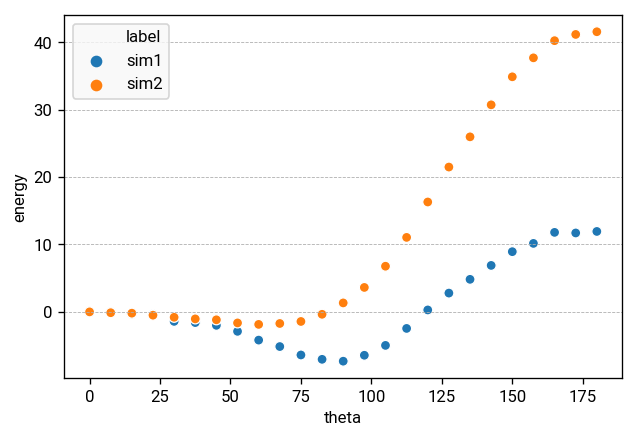

In [3]:
fig, ax = plt.subplots(dpi=120)
sns.scatterplot(x="theta", y="energy", hue="label", data=vector_sim_df, ax=ax);

### So now what?

*   We should fit the model (in machine learning terminology, we would "train" the model) to the data to obtain the interaction parameters.

*   This should be easy, I just need an input formula.

    \begin{equation}
    E(\theta{})=2J_{1}\cos\left(\theta{}\right)+2J_{2}\cos\left(2\theta{}\right)+2J_{3}\cos\left(3\theta{}\right)+\dots{}
    \end{equation}

*   Wait a second...

*   What is the problem here? Why can't I just go ahead and try fitting this now?

**We'll return to this later. But for now, let's talk about some simpler cases.**

## Basics of fitting in Python

### The *Filip* dataset

Source: <https://www.itl.nist.gov/div898/strd/lls/data/Filip.shtml>

The model that generated this dataset was a polynomial summation, $y=\beta_{0}+\beta_{1}x+\beta_{2}x^{2}+\beta_{3}x^{3}+\dots{}$.

In [4]:
filip_csv_path = Path("../../data/nist/filip.csv")
filip_df = pd.read_csv(filip_csv_path)

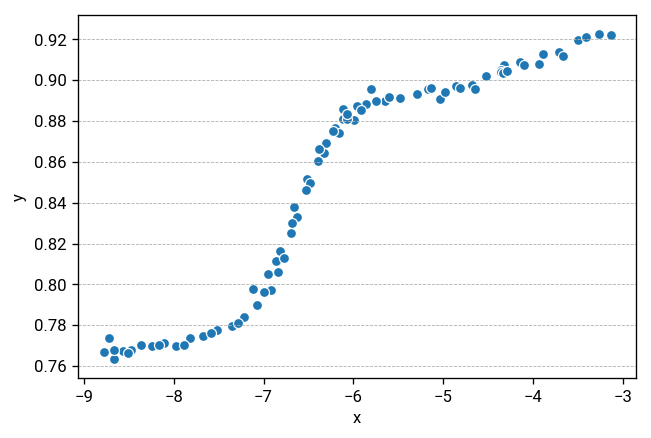

In [5]:
fig, ax = plt.subplots(dpi=120)
sns.scatterplot(x="x", y="y", data=filip_df, ax=ax);

We use the `statsmodels` package and its linear regression methods to perform a fit of the data. For this example, we will fit $y=\beta_{0}+\beta_{1}x+\beta_{2}x^2+\beta_{3}x^3$ to the data.

In [6]:
smf_filip_fit = smf.ols(data=filip_df, formula="y ~ x + I(x**2) + I(x**3)").fit()

The fitting coefficients (the parameters $\beta_{0}$, $\beta_{1}$, $\beta_{2}$, and $\beta_{3}$) are:

In [7]:
pd.DataFrame(smf_filip_fit.params, columns=["coefficients"])

,coefficients
Intercept,0.390271
x,-0.303364
I(x ** 2),-0.053719
I(x ** 3),-0.002726


We use the `predict` method to generate our model curve that we can compare with the data:

In [8]:
model_df = pd.DataFrame({"x": np.arange(-9, -3, 0.01)})
model_df["y"] = smf_filip_fit.predict(model_df)

Visualizing both on the same plot, we get:

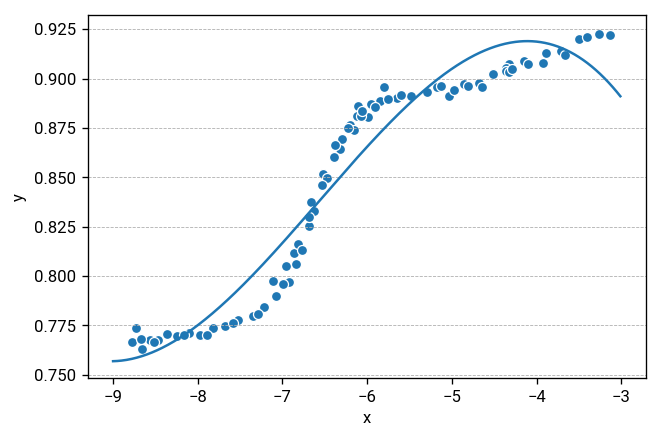

In [9]:
fig, ax = plt.subplots(dpi=120)
sns.scatterplot(x="x", y="y", data=filip_df, ax=ax)
sns.lineplot(x="x", y="y", data=model_df, ax=ax);

Obviously this is not that good a fit and we should try something else. But, how do we know when what we have is good enough? And, how do we know when we've gone too far?

### Overfitting

*   We cannot just keep trying additional terms until the fit "looks good"

*   This can lead to overfitting, where your model is too complicated and starts to closely fit to the pecularities of the training dataset

*   Put another way, you start fitting to statistical noise

*   Also means that the model won't generalize, meaning it only works for this very specific dataset

### Where data science comes in

How can we select the model that best fits the above data? Can we find the polynomial coefficients and the correct cutoff that generated this data?